In [41]:
!pwd

/scratch/connectome/jubin/ABCD-3DCNN/STEP_4_Multimodal-Learning/MultiChannel-Learning/contrastive_learning


In [8]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 18.8 MB/s eta 0:00:00


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import monai
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, Flip, ToTensor,CenterSpatialCrop
from monai.data import ImageDataset, NibabelReader
import nibabel as nib

In [2]:
os.chdir('/scratch/connectome/jubin/ABCD-3DCNN/STEP_4_Multimodal-Learning/MultiChannel-Learning/contrastive_learning/')

In [3]:
import os
import re
import glob
import random

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from monai.transforms import (AddChannel, Compose, CenterSpatialCrop, Flip, RandAffine,
                              RandFlip, RandRotate90, Resize, ScaleIntensity, ToTensor)
from monai.data import ImageDataset, NibabelReader

from dataloaders.custom_dataset import MultiModalImageDataset
from dataloaders.preprocessing import preprocessing_cat, preprocessing_num

ABCD_data_dir = {
    'fmriprep':'/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked/',
    'freesurfer':'/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/',
    'FA_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.1.FA_unwarpped_nii/',
    'FA_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.2.FA_warpped_nii/',
    'MD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.3.MD_unwarpped_nii/',
    'MD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/',
    'RD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.5.RD_unwarpped_nii/',
    'RD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.6.RD_warpped_nii/'
}

ABCD_phenotype_dir = {
    'total':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_phenotype_total.csv',
    'ADHD_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD.csv',
    'suicide_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_case.csv',
    'suicide_control':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_control.csv'
}

UKB_data_dir = '/scratch/connectome/3DCNN/data/2.UKB/1.sMRI_fs_cropped/'
UKB_phenotype_dir = '/scratch/connectome/3DCNN/data/2.UKB/2.demo_qc/UKB_phenotype.csv'


def case_control_count(labels, dataset_type, args):
    if args.cat_target:
        for cat_target in args.cat_target:
            curr_cnt = labels[cat_target].value_counts()
            print(f'In {dataset_type},\t"{cat_target}" contains {curr_cnt[1]} CASE and {curr_cnt[0]} CONTROL')

            
def loading_images(image_dir, args):
    image_files = pd.DataFrame()
    for brain_modality in args.data_type:
        curr_dir = image_dir[brain_modality]
        curr_files = pd.DataFrame({brain_modality:glob.glob(curr_dir+'*[yz]')}) # to get .npy(sMRI) & .nii.gz(dMRI) files
        curr_files[subjectkey] = curr_files[brain_modality].map(lambda x: x.split("/")[-1].split('.')[0])
        if args.dataset == 'UKB':
            curr_files[subjectkey] = curr_files[subjectkey].map(int)
        curr_files.sort_values(by=subjectkey, inplace=True)
        
        if len(image_files) == 0:
            image_files = curr_files
        else:
            image_files = pd.merge(image_files, curr_files, how='inner', on=subjectkey)
            
    if args.debug:
        image_files = image_files[:100]
        
    return image_files


def get_available_subjects(subject_data, args):
    case  = pd.read_csv(ABCD_phenotype_dir['ADHD_case'])[subjectkey]
    control = pd.read_csv(ABCD_phenotype_dir['suicide_control'])[subjectkey]
    filtered_subjectkey = pd.concat([case,control]).reset_index(drop=True)
    subject_data = subject_data[subject_data[subjectkey].isin(filtered_subjectkey)]
    
    return subject_data


def filter_phenotype(subject_data, filters):
    for fil in filters:
        fil_name, fil_option = fil.split(':')
        fil_option = np.float64(fil_option)
        subject_data = subject_data[subject_data[fil_name] == fil_option]
        
    return subject_data


def loading_phenotype(phenotype_dir, target_list, args):
    col_list = target_list + [subjectkey]

    ## get subject ID and target variables
    subject_data = pd.read_csv(phenotype_dir)
    subject_data = subject_data.loc[:,col_list]
    if 'Attention.Deficit.Hyperactivity.Disorder.x' in target_list:
        subject_data = get_available_subjects(subject_data, args)
    subject_data = filter_phenotype(subject_data, args.filter)
    subject_data = subject_data.sort_values(by=subjectkey)
    subject_data = subject_data.dropna(axis = 0)
    subject_data = subject_data.reset_index(drop=True)
    
    if (args.transfer == 'MAE' and args.dataset == 'ABCD') or args.scratch == 'MAE':
        return subject_data

    ### preprocessing categorical variables and numerical variables
    subject_data = preprocessing_cat(subject_data, args)
    subject_data = preprocessing_num(subject_data, args)
    
    return subject_data


def make_balanced_testset(il, num_test, args):
    n_case = num_test//2
    n_control = num_test - n_case

    t_case, rest_case = np.split(il[il[args.cat_target[0]]==0], (n_case,))
    t_control, rest_control = np.split(il[il[args.cat_target[0]]==1],(n_control,))
    
    test = pd.concat((t_case, t_control))
    rest = pd.concat((rest_case, rest_control))
    
    test = test.sort_values(by=subjectkey)
    rest = rest.sort_values(by=subjectkey)
    
    imageFiles_labels = pd.concat((rest,test)).reset_index(drop=True)
    
    return imageFiles_labels

# defining train,val, test set splitting function
def partition_dataset(imageFiles_labels, target_list, args):
    ## Define transform function
    resize = tuple(args.resize)
    
    default_transforms = [ScaleIntensity(), AddChannel(), Resize(resize), ToTensor()] 
    dMRI_transform = [CenterSpatialCrop(192)] + default_transforms
    aug_transforms = []
    
    if 'shift' in args.augmentation:
        aug_transforms.append(RandAffine(prob=0.1,translate_range=(0,2),padding_mode='zeros'))
    elif 'flip' in args.augmentation:
        aug_transforms.append(RandFlip(prob=0.1, spatial_axis=0))
    
    train_transforms, val_transforms, test_transforms = [], [], []
    for brain_modality in args.data_type:
        if re.search('FA|MD|RD',brain_modality) != None:
            train_transforms.append(Compose(dMRI_transform+aug_transforms))
            val_transforms.append(Compose(dMRI_transform))
            test_transforms.append(Compose(dMRI_transform))
        else:
            train_transforms.append(Compose(default_transforms+aug_transforms))
            val_transforms.append(Compose(default_transforms))
            test_transforms.append(Compose(default_transforms))

    ## Dataset split    
    num_total = len(imageFiles_labels)
    num_test = int(num_total*args.test_size)
    num_val = int(num_total*args.val_size) if args.cv == None else int((num_total-num_test)/5)
    num_train = num_total - (num_val+num_test)
    
    imageFiles_labels = make_balanced_testset(imageFiles_labels, num_test, args)
    images = imageFiles_labels[args.data_type]
    labels = imageFiles_labels[target_list]
    
    ## split dataset by 5-fold cv or given split size
    if args.cv == None:
        images_train, images_val, images_test = np.split(images, [num_train, num_train+num_val]) # revising
        labels_train, labels_val, labels_test = np.split(labels, [num_train, num_train+num_val])
    else:
        split_points = [num_val, 2*num_val, 3*num_val, 4*num_val, num_total-num_test]
        images_total, labels_total = np.split(images, split_points), np.split(labels, split_points)
        images_test, labels_test = images_total.pop(), labels_total.pop()
        images_val, labels_val = images_total.pop(args.cv-1), labels_total.pop(args.cv-1)
        images_train, labels_train = np.concatenate(images_total), np.concatenate(labels_total)
        num_train, num_val = images_train.shape[0], images_val.shape[0]
        
    print(f"Total subjects={num_total}, train={num_train}, val={num_val}, test={num_test}")

    ## make splitted dataset
    train_set = MultiModalImageDataset(image_files=images_train, labels=labels_train, transform=train_transforms)
    val_set = MultiModalImageDataset(image_files=images_val, labels=labels_val, transform=val_transforms)
    test_set = MultiModalImageDataset(image_files=images_test, labels=labels_test, transform=test_transforms)

    partition = {}
    partition['train'] = train_set
    partition['val'] = val_set
    partition['test'] = test_set

    case_control_count(labels_train, 'train', args)
    case_control_count(labels_val, 'validation', args)
    case_control_count(labels_test, 'test', args)

    return partition, imageFiles_labels

def make_dataset(args): # revising
    global subjectkey
    subjectkey = 'subjectkey' if args.dataset == 'ABCD' else 'eid'
    image_dir = ABCD_data_dir if args.dataset == 'ABCD' else UKB_data_dir
    phenotype_dir = ABCD_phenotype_dir['total'] if args.dataset == 'ABCD' else UKB_phenotype_dir
    target_list = args.cat_target + args.num_target
    
    image_files = loading_images(image_dir, args)
    subject_data = loading_phenotype(phenotype_dir, target_list, args)

    # combining image files & labels
    imageFiles_labels = pd.merge(subject_data, image_files, how='inner', on=subjectkey)

    # partitioning dataset and preprocessing (change the range of categorical variables and standardize numerical variables)
    partition = partition_dataset(imageFiles_labels, target_list, args)
    print("*** Making a dataset is completed *** \n")
    
    return partition, subject_data, imageFiles_labels

In [4]:
import os
import json
import argparse 

import pandas as pd
import torch

import models.simple3d as simple3d 
import models.vgg3d as vgg3d 
import models.resnet3d as resnet3d 
import models.densenet3d as densenet3d 
import models.sfcn as sfcn

parser = argparse.ArgumentParser()

# Options for model setting
parser.add_argument("--model", type=str, required=True, help='Select model. e.g. densenet3D121, sfcn.',
                    choices=['simple3D', 'sfcn', 'vgg3D11', 'vgg3D13', 'vgg3D16', 'vgg3D19',
                             'resnet3D50', 'resnet3D101', 'resnet3D152',
                             'densenet3D121', 'densenet3D169', 'densenet201', 'densenet264'])
parser.add_argument("--in_channels", default=1, type=int, help='')

# Options for dataset and data type, split ratio, CV, resize, augmentation
parser.add_argument("--dataset", type=str, choices=['UKB','ABCD'], required=True, help='Selelct dataset')
parser.add_argument("--data_type", nargs='+', type=str, help='Select data type(sMRI, dMRI)',
                    choices=['fmriprep', 'freesurfer', 'FA_unwarpped_nii', 'FA_warpped_nii',
                             'MD_unwarpped_nii', 'MD_warpped_nii', 'RD_unwarpped_nii', 'RD_warpped_nii'])
parser.add_argument("--val_size", default=0.1, type=float, help='')
parser.add_argument("--test_size", default=0.1, type=float, help='')
parser.add_argument("--cv", default=None, type=int, choices=[1,2,3,4,5], help="option for 5-fold CV. 1~5.")
parser.add_argument("--resize", nargs="*", default=(96, 96, 96), type=int, help='')
parser.add_argument("--augmentation", nargs="*", default=[], type=str, choices=['shift','flip'],
                    help="Data augmentation - [shift, flip] are available")

# Hyperparameters for model training
parser.add_argument("--lr", default=0.01, type=float, help='')
parser.add_argument("--lr_adjust", default=0.01, type=float, help='')
parser.add_argument("--epoch", type=int, required=True, help='')
parser.add_argument("--epoch_FC", type=int, default=0, help='Option for training only FC layer')
parser.add_argument("--optim", default='Adam', type=str, choices=['Adam','SGD','RAdam','AdamW'], help='')
parser.add_argument("--weight_decay", default=0.001, type=float, help='')
parser.add_argument("--scheduler", default='', type=str, help='') 
parser.add_argument("--early_stopping", default=None, type=int, help='')
parser.add_argument("--train_batch_size", default=16, type=int, help='')
parser.add_argument("--val_batch_size", default=16, type=int, help='')
parser.add_argument("--test_batch_size", default=1, type=int, help='')

# Options for experiment setting
parser.add_argument("--exp_name", type=str, required=True, help='')
parser.add_argument("--gpus", nargs='+', type=int, help='')
parser.add_argument("--sbatch", type=str, choices=['True', 'False'])
parser.add_argument("--cat_target", nargs='+', default=[], type=str, help='')
parser.add_argument("--num_target", nargs='+', default=[], type=str, help='')
parser.add_argument("--confusion_matrix",  nargs='*', default=[], type=str, help='')
parser.add_argument("--filter", nargs="*", default=[], type=str,
                    help='options for filter data by phenotype. usage: --filter abcd_site:10 sex:1')
parser.add_argument("--load", default='', type=str, help='Load model weight that mathces {your_exp_dir}/result/*{load}*')
parser.add_argument("--scratch", default='', type=str, help='Option for learning from scratch')
parser.add_argument("--transfer", default='', type=str, choices=['sex','age','simclr','MAE'],
                    help='Choose pretrained model according to your option')
parser.add_argument("--unfrozen_layer", default='0', type=str, help='Select the number of layers that would be unfrozen')
parser.add_argument("--init_unfrozen", default='', type=str, help='Initializes unfrozen layers')
parser.add_argument("--debug", default='', type=str, help='')


_StoreAction(option_strings=['--debug'], dest='debug', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='', metavar=None)

In [5]:
target="Attention.Deficit.Hyperactivity.Disorder.x"
data_type="freesurfer FA_warpped_nii"
model="sfcn"
epoch_FC="0"
epoch="5"
optim="AdamW"
scheduler="--scheduler on" # step_80"
batch="8"
val_size="0.1"
test_size="0.1"
lr="1e-3"
lr_adjust="--lr_adjust 1"
cfm="--confusion_matrix Attention.Deficit.Hyperactivity.Disorder.x"
unfrozen="all"
exp_name='test_dmri'

In [6]:
com = f'--cat_target {target} --dataset ABCD --data_type {data_type} --val_size {val_size} \
--test_size {test_size} --lr {lr} --optim {optim} --resize 80 80 80 \
--train_batch_size {batch} --val_batch_size {batch} --exp_name {exp_name} \
--model {model} --epoch {epoch} --epoch_FC {epoch_FC} --unfrozen_layer {unfrozen} --gpus 0 1'


args = parser.parse_args(com.split())
if args.cat_target == args.num_target:
    raise ValueError('--num-target or --cat-target should be specified')

print(f"*** Categorical target labels are {args.cat_target} and Numerical target labels are {args.num_target} *** \n")

partition, subject_data, il= make_dataset(args)

*** Categorical target labels are ['Attention.Deficit.Hyperactivity.Disorder.x'] and Numerical target labels are [] *** 

Total subjects=3991, train=3193, val=399, test=399
In train,	"Attention.Deficit.Hyperactivity.Disorder.x" contains 1376 CASE and 1817 CONTROL
In validation,	"Attention.Deficit.Hyperactivity.Disorder.x" contains 160 CASE and 239 CONTROL
In test,	"Attention.Deficit.Hyperactivity.Disorder.x" contains 200 CASE and 199 CONTROL
*** Making a dataset is completed *** 



/home/connectome/jubin/.conda/envs/MRI/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
partition

({'train': <dataloaders.custom_dataset.MultiModalImageDataset at 0x7fafb41e4850>,
  'val': <dataloaders.custom_dataset.MultiModalImageDataset at 0x7faf6cc7deb0>,
  'test': <dataloaders.custom_dataset.MultiModalImageDataset at 0x7faf6cc7d7f0>},
       Attention.Deficit.Hyperactivity.Disorder.x       subjectkey  \
 0                                            0.0  NDARINV263W8YMY   
 1                                            0.0  NDARINV26AW8K7K   
 2                                            0.0  NDARINV26V2CZ6Z   
 3                                            0.0  NDARINV26YB6ZJ9   
 4                                            0.0  NDARINV27BYY712   
 ...                                          ...              ...   
 3986                                         1.0  NDARINV2P5R504F   
 3987                                         1.0  NDARINV2RD4CZ7T   
 3988                                         1.0  NDARINV2T5K2NDJ   
 3989                                         1.0  NDARI

In [8]:
%matplotlib inline

In [9]:
sMRI.shape

NameError: name 'sMRI' is not defined

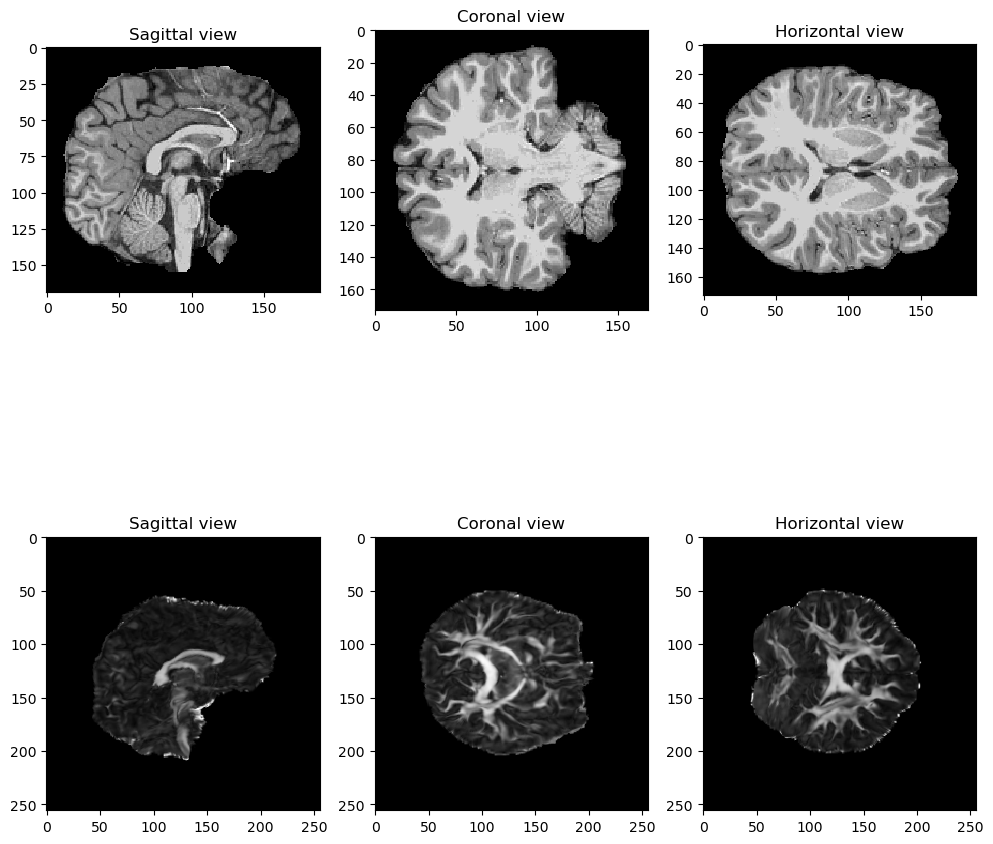

In [24]:
idx = 0
sMRI_dir = il['freesurfer'][idx]
dMRI_dir = il['FA_warpped_nii'][idx]

reader = NibabelReader()
sMRI = np.load(sMRI_dir)
dMRI = reader.read(dMRI_dir).get_fdata()
imgs = [sMRI, dMRI]

s = list(map(lambda x: (0,x-1,1), sMRI.shape))
s=s[0]
def plot_brain(s, c, h):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,12))

    shapes = list(map(lambda x: x.shape, imgs))
    criteria = ((s+1)/shapes[0][0], (h+1)/shapes[0][1], (c+1)/shapes[0][2])
    
    scaled_shapes = list(map(lambda x, crit: int(x*crit-1), shapes[1], criteria))
    s_, h_, c_ = zip((s,h,c), scaled_shapes)
    
    for i, ax in enumerate(axes):
        j = i*3
        if i == 1:
            ax[0].imshow(np.rot90(imgs[i][s_[i],:,:]), cmap='gray')
            ax[0].set_title('Sagittal view')
        else:
            ax[0].imshow(imgs[i][s_[i],:,:], cmap='gray')
            ax[0].set_title('Sagittal view')

        ax[1].imshow(imgs[i][:,:,c_[i]], cmap='gray')
        ax[1].set_title('Coronal view')

        ax[2].imshow(imgs[i][:,h_[i],:], cmap='gray')
        ax[2].set_title('Horizontal view')
    
    plt.show()

plot_brain(85, 90, 70)
# interact_manual(plot_brain, s=s[0], h=s[1], c=s[2]);


In [6]:
interact_manual?

Object `interact_manual` not found.


In [7]:
monai_transform = Compose([ScaleIntensity(),
                           AddChannel(),
#                            CenterSpatialCrop(192),
#                            monai.transforms.RandAffine(prob=1,translate_range=(0,40),padding_mode='zeros'),
#                            monai.transforms.RandFlip(prob=1, spatial_axis=0),
                           Resize((96,96,96))])
transformed_img = monai_transform(img_array)[0]
img = img_array
print(transformed_img.shape)
s, h, c = transformed_img.shape
img_array = transformed_img
interact(plot_brain, sag=(0,s-1,1), cor=(0,c-1,1), hor=(0,h-1,1));

NameError: name 'Compose' is not defined

In [22]:
img_array = np.load(img_dir)
s, h, c = np.load(img_dir).shape

interact_manual(plot_brain, sag=(0,s-1,1), cor=(0,c-1,1), hor=(0,h-1,1));

interactive(children=(IntSlider(value=70, description='sag', max=141), IntSlider(value=87, description='cor', …

In [23]:
s,h,c

(142, 157, 176)

In [39]:
transformed_img

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [2]:
adhd=pd.read_csv('/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD.csv')

In [29]:
adhd

,subjectkey,age,sex,race.ethnicity,high.educ,income,married,abcd_site,height,weight,...,Substance.Use.Disorder.x,Other.Drugs.Use.Disorder.x,Sedative.Hypnotic.or.Anxiolytic.Use.Disorder.x,Other.Specified.Trauma.and.Stressor.Related.Disorder.x,Post.Traumatic.Stress.Disorder.x,HOMICIDAL.IDEATION.AND.BEHAVIOR.x,totalBIS,totalBAS,PPSP_frequency,PPSP_distress
0,NDARINV00BD7VDC,112.0,1.0,1.0,20.0,10.0,1.0,7.0,57.50,76.800000,...,0,0,0,0,0,0,11,13,0,0
1,NDARINV00CY2MDM,130.0,1.0,1.0,15.0,6.0,4.0,20.0,56.50,91.500000,...,0,0,0,0,0,0,5,10,0,0
2,NDARINV00LJVZK2,121.0,1.0,5.0,11.0,1.0,5.0,11.0,53.50,81.400000,...,0,0,0,0,0,0,17,18,2,0
3,NDARINV00U4FTRU,130.0,2.0,5.0,12.0,6.0,6.0,4.0,52.50,96.966667,...,0,0,0,1,0,0,18,30,17,83
4,NDARINV0182J779,111.0,2.0,1.0,21.0,9.0,1.0,6.0,54.00,74.000000,...,0,0,0,0,0,0,10,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,NDARINVZCGL10MP,131.0,1.0,2.0,16.0,4.0,5.0,14.0,56.25,72.250000,...,0,0,0,0,0,0,11,19,0,0
2502,NDARINVZE3C6X7E,120.0,1.0,5.0,18.0,9.0,1.0,14.0,58.00,109.500000,...,0,0,0,0,0,0,8,24,0,0
2503,NDARINVZEB043HN,128.0,2.0,1.0,19.0,9.0,5.0,13.0,40.75,72.000000,...,0,0,0,0,0,0,8,28,0,0
2504,NDARINVZEKA1L7D,116.0,1.0,1.0,18.0,7.0,1.0,13.0,NaN,67.000000,...,0,0,0,0,0,0,10,19,4,8


In [12]:
list(adhd.columns)

['subjectkey',
 'age',
 'sex',
 'race.ethnicity',
 'high.educ',
 'income',
 'married',
 'abcd_site',
 'height',
 'weight',
 'BMI',
 'vol',
 'nihtbx_totalcomp_uncorrected',
 'nihtbx_fluidcomp_uncorrected',
 'nihtbx_pattern_uncorrected',
 'nihtbx_picture_uncorrected',
 'nihtbx_list_uncorrected',
 'nihtbx_flanker_uncorrected',
 'nihtbx_cardsort_uncorrected',
 'nihtbx_cryst_uncorrected',
 'nihtbx_reading_uncorrected',
 'nihtbx_picvocab_uncorrected',
 'poa_total_6month_follow_up',
 'friends',
 'close_friends',
 'upps_negative_urgency',
 'upps_lack_of_planning',
 'upps_sensation_seeking',
 'upps_positive_urgency',
 'upps_lack_of_perseverance',
 'upps_total',
 'AnxDep.CBCL',
 'WithDep.CBCL',
 'Somatic.CBCL',
 'Social.CBCL',
 'Thought.CBCL',
 'Attention.CBCL',
 'RuleBreak.CBCL',
 'Aggressive.CBCL',
 'Internal.CBCL',
 'External.CBCL',
 'TotProb.CBCL',
 'Depress.CBCL',
 'AnxDisord.CBCL',
 'SomaticPr.CBCL',
 'ADHD.CBCL',
 'Opposit.CBCL',
 'Conduct.CBCL',
 'Sluggish.Cognitive.Tempo..SCT..CBCL',
 '

In [18]:
adhd[ 'Attention.Deficit.Hyperactivity.Disorder.x'].describe()

count    2506.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Attention.Deficit.Hyperactivity.Disorder.x, dtype: float64

In [26]:
tot=pd.read_csv('/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_phenotype_total.csv')

In [27]:
tot.describe()

,age,sex,race.ethnicity,high.educ,income,married,abcd_site,height,weight,BMI,...,Substance.Use.Disorder.x,Other.Drugs.Use.Disorder.x,Sedative.Hypnotic.or.Anxiolytic.Use.Disorder.x,Other.Specified.Trauma.and.Stressor.Related.Disorder.x,Post.Traumatic.Stress.Disorder.x,HOMICIDAL.IDEATION.AND.BEHAVIOR.x,totalBIS,totalBAS,PPSP_frequency,PPSP_distress
count,11536.000000,11531.000000,11519.000000,11517.000000,10555.000000,11445.000000,11536.000000,11526.000000,11524.000000,11522.000000,...,11702.000000,11702.000000,11866.000000,11683.000000,11683.000000,11702.000000,11869.000000,11869.000000,11875.000000,11875.000000
mean,118.953190,1.475934,2.035246,16.606842,7.230886,2.092442,11.445995,55.265927,82.538557,18.811432,...,0.000085,0.000085,0.000084,0.030386,0.019772,0.005982,9.493218,20.810262,2.630147,4.637895
std,7.464702,0.499442,1.323308,2.759331,2.412037,1.719346,6.080634,3.209198,23.621102,4.225132,...,0.009244,0.009244,0.009180,0.171654,0.139223,0.077114,3.771319,6.933897,3.558714,9.089124
min,108.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.650000,23.900000,5.266641,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112.000000,1.000000,1.000000,15.000000,6.000000,1.000000,6.000000,53.000000,66.100000,15.939709,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,16.000000,0.000000,0.000000
50%,119.000000,1.000000,1.000000,18.000000,8.000000,1.000000,12.000000,55.100000,76.500000,17.649024,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,20.000000,1.000000,0.000000
75%,125.000000,2.000000,3.000000,19.000000,9.000000,3.000000,16.000000,57.200000,93.000000,20.625950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,25.000000,4.000000,6.000000
max,131.000000,2.000000,5.000000,21.000000,10.000000,6.000000,22.000000,82.000000,272.000000,54.992926,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,39.000000,21.000000,94.000000


In [19]:
cont=pd.read_csv('/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_control.csv')

In [28]:
list(cont.columns)

['subjectkey',
 'Bipolar.I.Disorder.x',
 'Bipolar.II.Disorder.x',
 'Unspecified.Bipolar.and.Related.Disorder.x',
 'Major.Depressive.Disorder.x',
 'Persistent.Depressive.Disorder.x',
 'Unspecified.Depressive.Disorder.x',
 'Social.Anxiety.Disorder.x',
 'Generalized.Anxiety.Disorder.x',
 'SelfInjuriousBehaviorwithoutsuicidalintent.x',
 'SuicidalideationPassive.x',
 'SuicidalideationActive.x',
 'PreparatoryActionstowardimminentSuicidalbehavior.x',
 'InterruptedAttempt.x',
 'AbortedAttempt.x',
 'SuicideAttempt.x',
 'SLEEP.PROBLEMS.x',
 'Unspecified.Schizophrenia.Spectrum.and.Other.Psychotic.Disorder.x',
 'Hallucinations.x',
 'Delusions.x',
 'Associated.Psychotic.Symptoms.x',
 'Panic.Disorder.x',
 'Separation.Anxiety.Disorder.x',
 'Specific.Phobia.x',
 'Obsessive.Compulsive.Disorder.x',
 'Other.Specified.Obsessive.Compulsive.and.Related.Disorder.x',
 'Binge.Eating.Disorder.x',
 'Anorexia.Nervosa.x',
 'Bulimia.Nervosa.x',
 'Other.Specified.Feeding.or.Eating.Disorder.Bulimia.Nervosa.x',
 'Unsp

In [25]:
for c in cont:
    print(cont[c].describe())

count                3108
unique               3108
top       NDARINV005V6D2C
freq                    1
Name: subjectkey, dtype: object
count    3108.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Bipolar.I.Disorder.x, dtype: float64
count    3108.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Bipolar.II.Disorder.x, dtype: float64
count    3108.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Unspecified.Bipolar.and.Related.Disorder.x, dtype: float64
count    3108.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Major.Depressive.Disorder.x, dtype: float64
count    3108.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Persistent.Depre